### Imports

In [6]:
# Scinet modules
from scinet import *
import scinet.ed_oscillator as osc

#Other modules
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

### Helper Functions (copied from oscillator example)

In [7]:
def osc_eqn(A_0, delta_0, b, kappa, t):
    return np.real(A_0 * np.exp(-b / 2. * t) * np.exp(1 / 2. * np.sqrt(b**2 - 4 * kappa + 0.j) * t + 1.j * delta_0))

def gen_input(A_0, delta_0, b, kappa, tt_predicted):
    tt_in = np.linspace(0, 5, 50)
    in1 = np.array([osc_eqn(A_0, delta_0, b, kappa, tt_in) for _ in tt_predicted])
    in2 = np.reshape(tt_predicted, (-1, 1))
    out = in2 #dummy filler
    return [in1, in2, out]

def pendulum_prediction(net, b, kappa):    
    tt_given = np.linspace(0, 10, 250)
    tt_predicted = np.linspace(0, 10, 250)
    a_given = osc_eqn(1, 0, b, kappa, tt_given)
    a_precicted = net.run(gen_input(1, 0, b, kappa, tt_predicted), net.output).ravel()
    fig = plt.figure(figsize=(3.4, 2.1))
    ax = fig.add_subplot(111)
    ax.plot(tt_given, a_given, color=orange_color, label='True time evolution')
    ax.plot(tt_predicted, a_precicted, '--', color=blue_color, label='Predicted time evolution')
    ax.set_xlabel(r'$t$ [$s$]')
    ax.set_ylabel(r'$x$ [$m$]')
    handles, labels = ax.get_legend_handles_labels()
    lgd=ax.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.6, 1.3), shadow=True, ncol=1)
    fig.tight_layout()
    return fig

def osc_representation_plot(net, b_range, kappa_range, step_num=100, eval_time=7.5):
    bb = np.linspace(*b_range, num=step_num)
    kk = np.linspace(*kappa_range, num=step_num)
    B, K = np.meshgrid(bb, kk)
    out = np.array([net.run(gen_input(1, 0, b, kappa, [eval_time]), net.mu)[0] for b, kappa in zip(np.ravel(B), np.ravel(K))])
    fig = plt.figure(figsize=(net.latent_size*3.9, 2.1))
    for i in range(net.latent_size):
        zs = out[:, i]
        ax = fig.add_subplot('1{}{}'.format(net.latent_size, i + 1), projection='3d')
        Z = np.reshape(zs, B.shape)
        surf = ax.plot_surface(B, K, Z, rstride=1, cstride=1, cmap=cm.inferno, linewidth=0)
        ax.set_xlabel(r'$b$ [$kg/s$]')
        ax.set_ylabel(r'$\kappa$ [$kg/s^2$]')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        if (i==2):
            ax.set_zlim(-1,1) #Fix the scale for the third plot, where the activation is close to zero
        ax.set_zticks([-1,-0.5,0,0.5,1])
    fig.tight_layout()
    return fig

In [8]:
blue_color='#000cff'
orange_color='#ff7700'

### Input Variables

In [9]:
observation_size = 50
latent_size = 3
question_size = 1
answer_size = 1
dev_percent = 10
num_examples = 50000

### Data creation and loading

In [10]:
osc.oscillator_data(num_examples, fileName='oscillator_example');


In [11]:
td, vd, ts, vs, proj = dl.load(dev_percent, 'oscillator_example')

### Create and train neural network

In [12]:
# Create network object
net = nn.Network(observation_size, latent_size, question_size, answer_size) 

In [13]:
# Print initial reconstruction loss (depends on initialization)
print(net.run(vd, net.recon_loss)) #default
print(net.run(vd, net.kl_loss))

0.7208405
1.5483416


In [14]:
# Train
net.train(50, 256, 0.001, td, vd)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
# Check progress. It is recommended to use Tensorboard instead for this.
print(net.run(vd, net.recon_loss)) #default
print(net.run(vd, net.kl_loss))

0.0035246697
4.002035


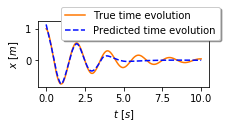

In [16]:
# Plot prediction
b_damper = 0.6
k_spring = 10.0
pendulum_prediction(net, b_damper, k_spring);

In [17]:
%matplotlib tk
osc_representation_plot(net, [0.5, 1], [5, 10]);